# Evaluating image generation using NLTK synset lemmas vs using NLTK synset gloss(es)

## Requirements installation

In [ ]:
# THIS IS ONLY REQUIRED IF THE NOTEBOOK IS RUNNING ON GOOGLE COLAB

!sudo apt-get update -y
!sudo apt-get install python3.10 python3.10-dev python3.10-distutils libpython3.10-dev

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 2

# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

#install colab's dependencies
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor ipywidgets widgetsnbextension

# link to the old google package
!ln -s /usr/local/lib/python3.7/dist-packages/google \
       /usr/local/lib/python3.10/dist-packages/google

from google.colab import output
output.enable_custom_widget_manager()
!jupyter nbextension enable --py widgetsnbextension

# NOW RELOAD, THEN PROCEED

In [ ]:
!pip install install -U daam accelerate tqdm -q

import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

## Loading 5 example synset

In [1]:
from nltk.corpus import wordnet as wn
from pprint import pprint

synsets = [wn.synset('dog.n.01'),wn.synset('mansion.n.02'),wn.synset('grape.n.02'),wn.synset('sofa.n.01'),wn.synset('church.n.02')]
lemmas = []
for synset in synsets:
    lem = [str(lemma.name()).replace("_", " ") for lemma in synset.lemmas()]
    lemmas.append(', '.join(lem))
glosses = [synset.definition().replace(")", "").replace("(", "") for synset in synsets]

print('Lemmas:')
pprint(lemmas)
print('Glosses:')
pprint(glosses)

Lemmas:
['dog, domestic dog, Canis familiaris',
 'mansion, mansion house, manse, hall, residence',
 'grape, grapevine, grape vine',
 'sofa, couch, lounge',
 'church, church building']
Glosses:
['a member of the genus Canis probably descended from the common wolf that has '
 'been domesticated by man since prehistoric times; occurs in many breeds',
 'a large and imposing house',
 'any of numerous woody vines of genus Vitis bearing clusters of edible '
 'berries',
 'an upholstered seat for more than one person',
 'a place for public especially Christian worship']


## Image generation

### Initializing the model

In [2]:
from matplotlib import pyplot as plt
from daam import trace, set_seed, plot_overlay_heat_map, expand_image
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from tqdm import tqdm
import torch

model = "stabilityai/stable-diffusion-2-base"
# enabling cuDNN auto-tuner for faster convolution
torch.backends.cudnn.benchmark = True
pipe = StableDiffusionPipeline.from_pretrained(
    model,
    device_map="auto",
    safety_checker=None)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()
generator = set_seed(26111998)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

### Generating 5 images with stable diffusion using LEMMAS

In [3]:
def show_heat_map(pipe, prompt, word, type):
  plt.axis('off')
  plt.clf()
  heat_map = tc.compute_global_heat_map()
  heat_map = expand_image(heat_map.compute_word_heat_map(word))
  plot_overlay_heat_map(pipe.images[0], heat_map)
  plt.savefig(f'plot_{type}_{word}.png')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

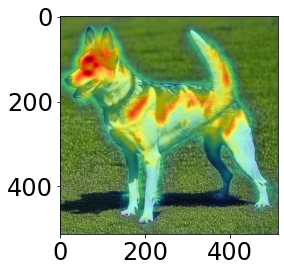

In [4]:
images_paths = []

with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
  with trace(pipe) as tc:
    for counter, lemma in enumerate(lemmas):
      out = pipe(lemma, negative_prompt="writing, letters, handwriting, words",
          num_inference_steps=30,
          generator=generator,
          guidance_scale=7.5)
      out.images[0].save(f"lemma_{counter}.png")
      images_paths.append(f"lemma_{counter}.png")
      if counter == 0:
        show_heat_map(out, lemma, "dog", "lemma")

### Generating 5 images with stable diffusion using GLOSSES

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

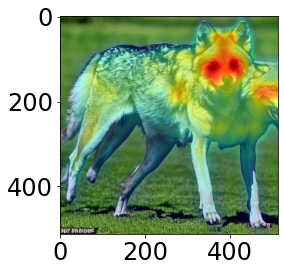

In [5]:
images_path_glosses = []

with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
  with trace(pipe) as tc:
    for counter, gloss in enumerate(glosses):
      out = pipe(gloss, negative_prompt="writing, letters, handwriting, words",
          num_inference_steps=30,
          generator=generator,
          guidance_scale=7.5)
      out.images[0].save(f"gloss_{counter}.png")
      images_path_glosses.append(f"gloss_{counter}.png")
      if counter == 0:
        show_heat_map(out, lemma, "wolf", "gloss")

## Display the images and final results and considerations

### Lemmas images

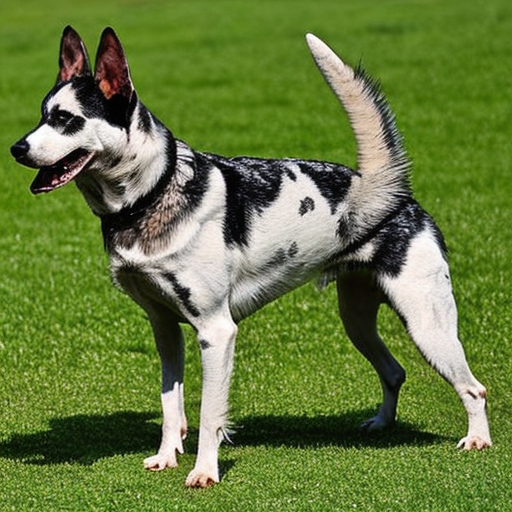

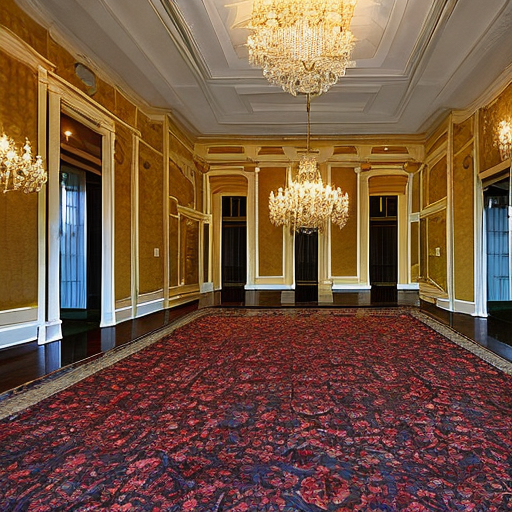

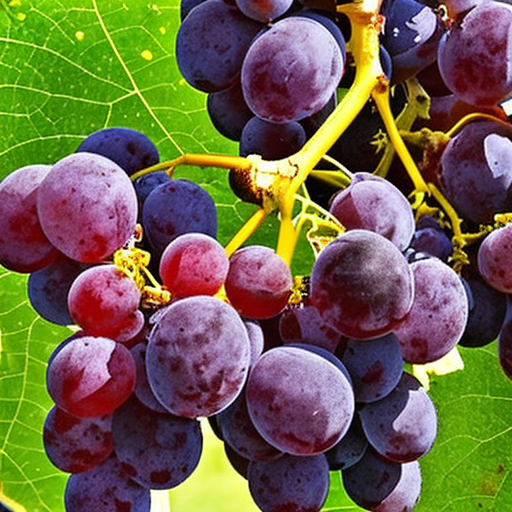

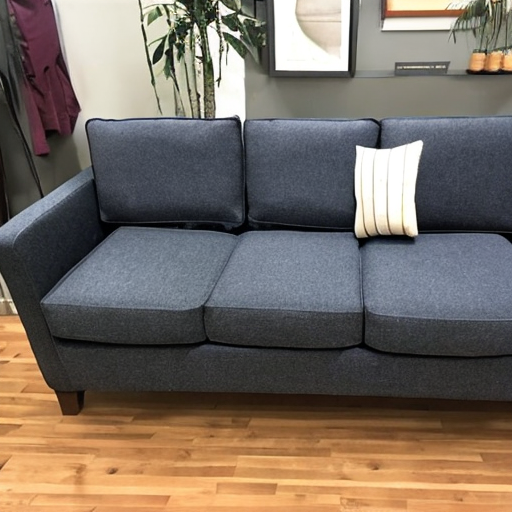

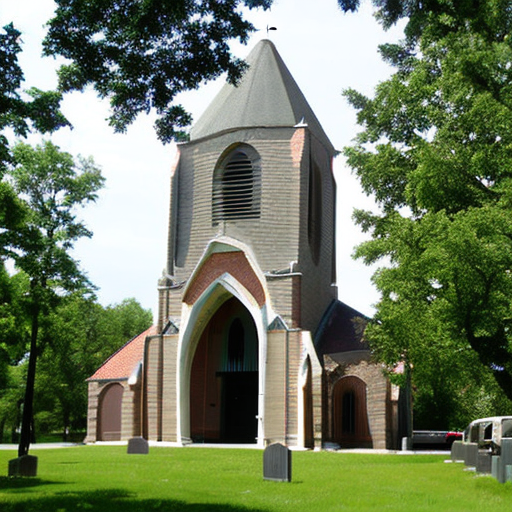

In [6]:
from IPython.display import Image, display

for image_path in images_paths:
    display(Image(filename=image_path))

### Glosses images

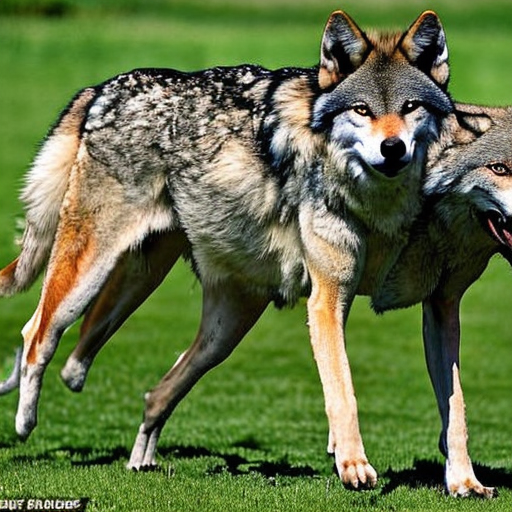

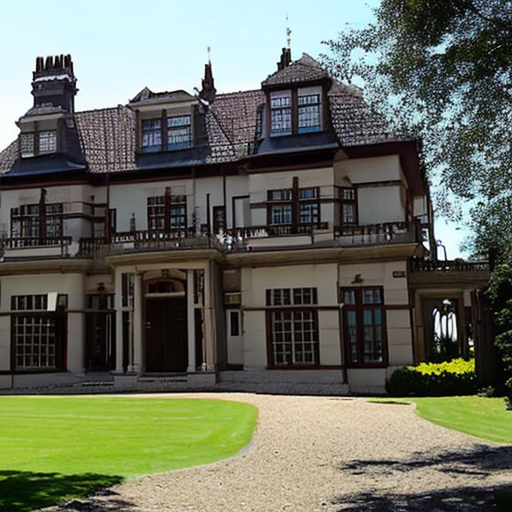

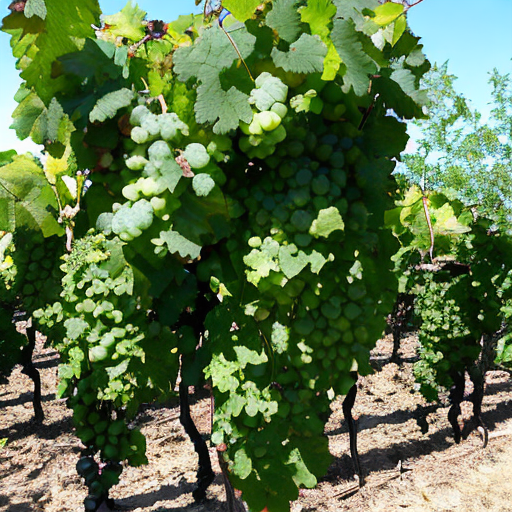

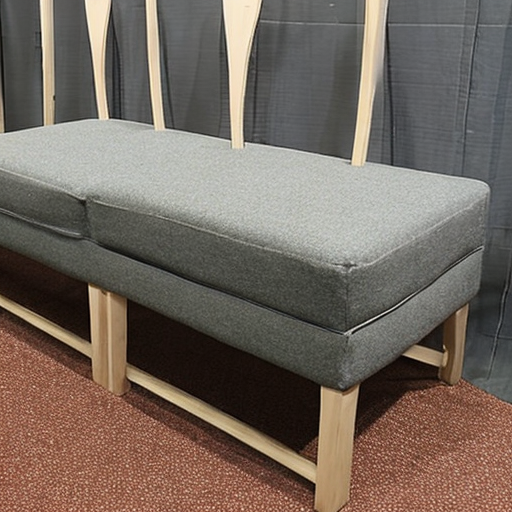

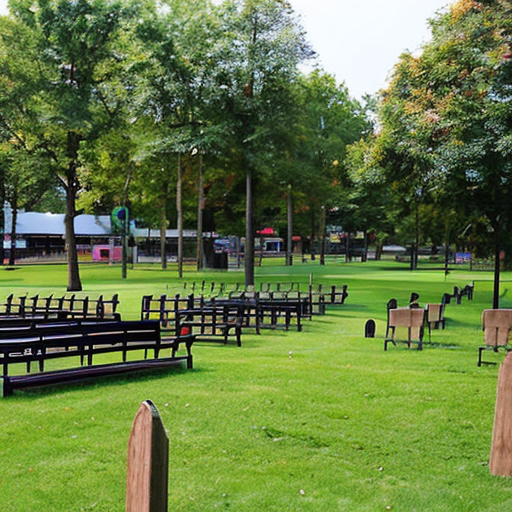

In [7]:
for image_path in images_path_glosses:
    display(Image(filename=image_path))

## Review of the images and conclusion

It is clear, just by watching the different images, that glosses are not ideal for image generation. Let's analyze all the different images, comparing the prompts and the generated image.

Let's start with *dog.n.01*. For the lemmas, we have "dog, domestic dog, Canis familiaris": which leaves room for machine interpretation. The generated image is of a dog running. This perfectly fits our model.
For the glosses, we have "a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds": this description overfits the model so much that the generated image is, in fact, of a wolf and not a dog.

The same process applies for the sofa: the description overfits our model and causes it to generate a *chair for two*.

For the last image, the problem is very, very clear: the model does not have a subject to generate, and it defaults to a visual description. This happens a lot with glosses, and it is a secondary problem originating from what was previously described.

## Interpretation of the output using Cross Attention

Now we are going to analyse the first example and interpret the results using DAAM maps, as described in [this paper](https://arxiv.org/abs/2210.04885).

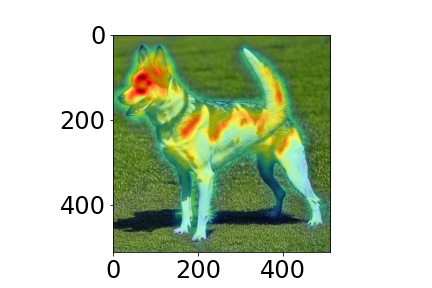

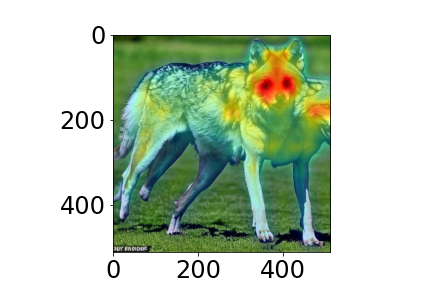

In [8]:
import glob

display(Image(filename="plot_lemma_dog.png"))
display(Image(filename="plot_gloss_wolf.png"))

We can investigate, using DAAM, the two images generating heatmaps on tokens where the attention is higher.
One thing that is clear is that we cannot map "dog" on the second image, because the tokenizer doesn't even have the token in the prompt. This might be the main reason why a wolf is then represented: SD, lacking of a "dog" subject, thinks that the "wolf" token is the subject of the phrase and assigns higher attention on that, resulting in a wolf image.